<a href="https://colab.research.google.com/github/Santa7714x/Sanjay-fab7/blob/main/Classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import shutil
import random

# Define source and destination paths
source_dir = '/content/drive/MyDrive/images(STI)'
train_dir = '/content/drive/MyDrive/train'
val_dir = '/content/drive/MyDrive/validation'
test_dir = '/content/drive/MyDrive/test'

# Create train, validation, and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split the images while ensuring each defect class is represented
for defect_class in os.listdir(source_dir):  # Iterate through defect class folders
    class_path = os.path.join(source_dir, defect_class)

    if os.path.isdir(class_path):  # Check if it's a directory (defect class)
        images = os.listdir(class_path)  # List images within the defect class folder
        random.shuffle(images)

        # Calculate the number of images for each split
        train_split = int(0.8 * len(images))
        val_split = int(0.1 * len(images))

        # Select images for each split
        train_images = images[:train_split]
        val_images = images[train_split:train_split + val_split]
        test_images = images[train_split + val_split:]

        # Ensure directories for each defect class in train, validation, and test
        os.makedirs(os.path.join(train_dir, defect_class), exist_ok=True)
        os.makedirs(os.path.join(val_dir, defect_class), exist_ok=True)
        os.makedirs(os.path.join(test_dir, defect_class), exist_ok=True)

        # Move images to train directory
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, defect_class, img))

        # Move images to validation directory
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, defect_class, img))

        # Move images to test directory
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, defect_class, img))

print("Data successfully split into train, validation, and test folders.")

Data successfully split into train, validation, and test folders.


Using device: cpu
Epoch [1/2], Train Loss: 2.2604, Train Accuracy: 40.78%
Validation Loss: 1.9259, Validation Accuracy: 45.75%
Epoch [2/2], Train Loss: 1.9471, Train Accuracy: 46.18%
Validation Loss: 1.7551, Validation Accuracy: 48.68%


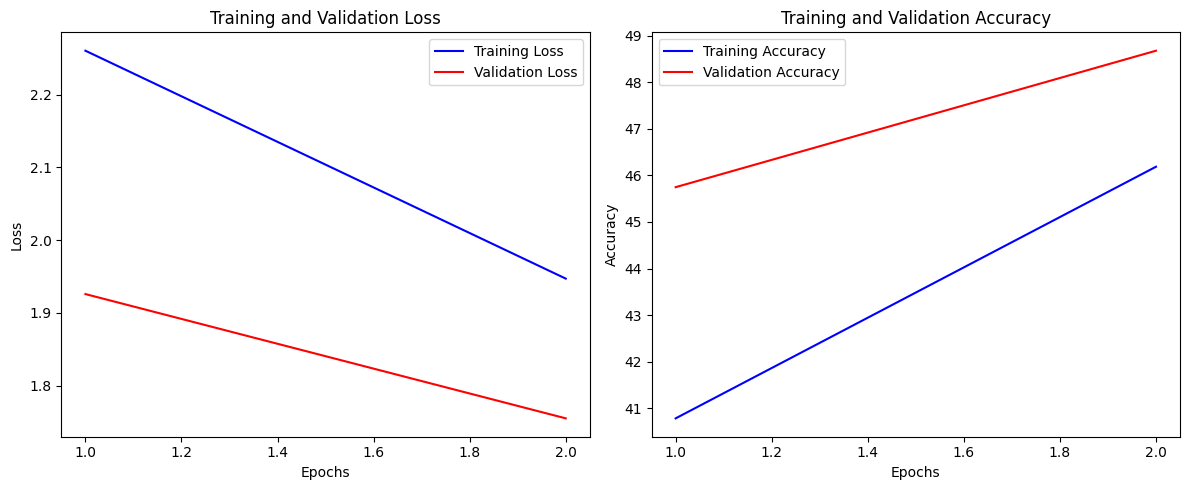

Test Accuracy: 48.61%
Model training complete and saved as 'defect_classification_model.pth'


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set paths
train_dir = '/content/drive/MyDrive/train'
val_dir = '/content/drive/MyDrive/validation'
test_dir = '/content/drive/MyDrive/test'

# Parameters
batch_size = 32
num_epochs = 2

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data transformations without resizing or cropping
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load data without splitting
all_data = datasets.ImageFolder('/content/drive/MyDrive/images(STI)', transform=train_transform)
num_classes = len(all_data.classes)

# Calculate split sizes
total_size = len(all_data)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_data, val_data, test_data = random_split(all_data, [train_size, val_size, test_size])

# Use DataLoader for each split
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * (224 // 8) * (224 // 8), 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNNModel(num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store metrics for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plotting Loss and Accuracy curves
epochs = range(1, num_epochs + 1)

# Loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Test the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), 'defect_classification_model.pth')
print("Model training complete and saved as 'defect_classification_model.pth'")


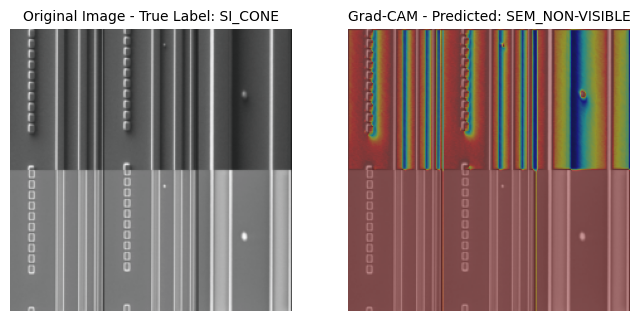

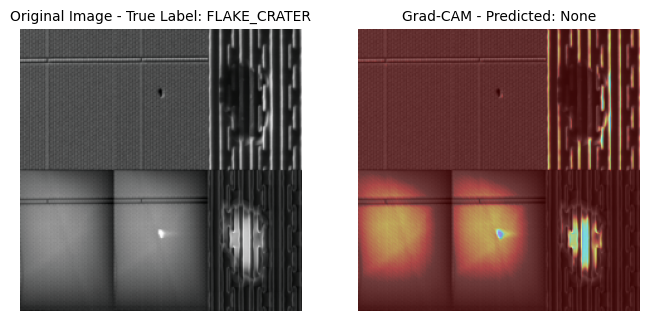

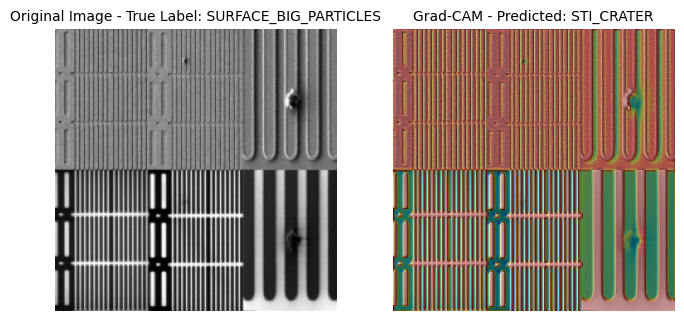

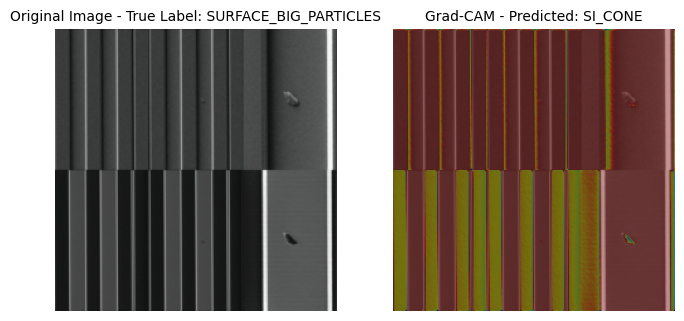

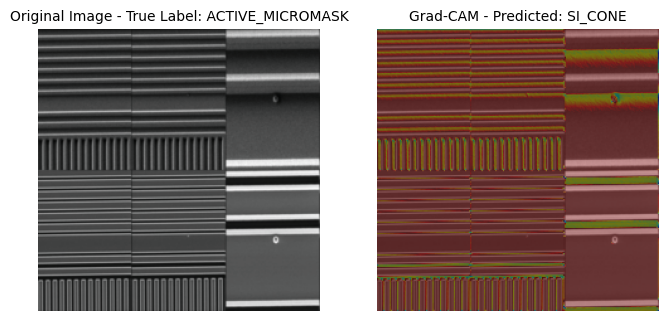

In [17]:
# Import necessary libraries
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the model
model = CNNModel(num_classes=num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/defect_classification_model.pth', map_location=device, weights_only=True))
model = model.to(device)
model.eval()

# Define the layer for Grad-CAM visualization
# Correct the target layer to model.conv1 to match the input image channels
target_layer = model.conv1

# Function to get Grad-CAM heatmap
def gradcam(model, image, label, target_layer):
    # Forward pass
    image = image.unsqueeze(0).to(device)
    output = model(image)
    predicted_class = output.argmax(dim=1).item()

    # Check if it's a misclassification
    if predicted_class == label:
        return None, None  # Skip correctly classified images

    # Backward pass to get gradients
    model.zero_grad()
    class_score = output[0, predicted_class]
    class_score.backward(retain_graph=True)

    # Get gradients and activations
    gradients = target_layer.weight.grad.cpu().data.numpy()[0]
    activations = target_layer(image).cpu().data.numpy()[0]

    # Global average pooling of gradients
    weights = np.mean(gradients, axis=(1, 2))

    # Weight the activations
    cam = np.zeros(activations.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activations[i]

    # Normalize the heatmap
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam -= cam.min()
    cam /= cam.max()

    return cam, predicted_class

# Load the test dataset for misclassified images
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load test dataset
test_data = datasets.ImageFolder('/content/drive/MyDrive/test', transform=test_transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

# Visualize Grad-CAM heatmaps for misclassified images
misclassified_count = 0  # Initialize a counter for misclassified images
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    cam, predicted_class = gradcam(model, images[0], labels.item(), target_layer)

    # Skip correctly classified images
    if cam is None:
        continue

    # Convert image back to CPU for visualization
    image = images[0].cpu().permute(1, 2, 0).numpy()
    image = np.array((image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255).astype(np.uint8)

    # Apply heatmap on image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

    # Plot the image and the Grad-CAM heatmap
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image - True Label: {test_data.classes[labels.item()]}", fontsize=10)
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM - Predicted: {test_data.classes[predicted_class]}", fontsize=10)
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.show()

    misclassified_count += 1  # Increment the counter for misclassified images
    if misclassified_count >= 5:  # Check if 5 misclassifications have been displayed
        break  # Exit the loop if 5 have been shown